# Importing Necessary Libraries

In [ ]:
%matplotlib inline
from IPython import display
import os
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.metrics import *
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator

np.random.seed(42)
tf.random.set_seed(42)

**Initial** **Parameters**

In [ ]:
#Setting some inital parameters
height, width = 224, 224
batch_size=64

## Dividing Training and Testing Dataset in **80:20** ratio

In [ ]:
data_dir = '/content/drive/MyDrive/CSE422 Dataset/brain_tumor_dataset'


def image_generator(height,width):
    datagen = ImageDataGenerator(
            rescale=1./255.,
            validation_split=0.2,
            )
    train_ds = datagen.flow_from_directory(
            data_dir,
            batch_size=batch_size,
            subset="training",
            shuffle=True,
            class_mode='binary',
            target_size=(height, width),
            #color_mode = 'rgb',
            classes={'no': 0., 'yes': 1.}
            )

    test_ds = datagen.flow_from_directory(
            data_dir,
            subset="validation",
            class_mode='binary',
            target_size=(height, width),
            batch_size=batch_size,
            #color_mode = 'rgb',
            classes={'no': 0., 'yes': 1.}
            )

    return train_ds, test_ds

train_ds, test_ds = image_generator(height,width)

total_image = np.concatenate([train_ds.labels,test_ds.labels])
print('\n\n',{'No_brain_tumor_cases':len(np.where(total_image==0)[0]),
      'brain_tumor_cases':len(np.where(total_image==1)[0])})

Found 203 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


 {'No_brain_tumor_cases': 98, 'brain_tumor_cases': 155}


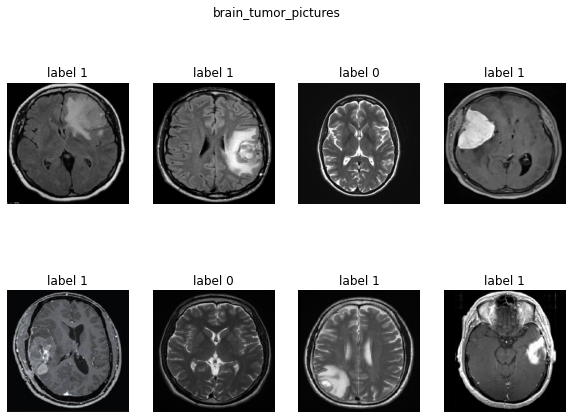

In [ ]:
fig, ax = plt.subplots(2, 4, figsize=(10, 7))
fig.suptitle("brain_tumor_pictures")
for k in range(8):
    images, labels = train_ds.next()
    i, j = k//4, k%4
    ax[i, j].imshow(images[0])
    ax[i, j].set_title(f'label {int(labels[0])}')
    ax[i, j].axis('off')
plt.show()

# Data Augmentation

In [ ]:
def augmentataion_generator(height,width):
    datagen = ImageDataGenerator(
            rescale=1./255.,
            width_shift_range=0.1,
            height_shift_range=0.1,
            shear_range=0.1,
            zoom_range=0.1,
            rotation_range=30,
            horizontal_flip=True,
            brightness_range=(0.5, 1.0)
            )
    aug_train_ds = datagen.flow_from_directory(
            data_dir,
            batch_size=128,
            shuffle=True,
            class_mode='binary',
            #color_mode = 'rgb',
            target_size=(height, width),
            classes={'no': 0., 'yes': 1.}
            )
    return aug_train_ds
aug_train_ds = augmentataion_generator(height,width)

Found 253 images belonging to 2 classes.


## **VGG19**

In [ ]:
from tensorflow.keras.layers.experimental import preprocessing

tf.keras.backend.clear_session()
input_shape = (height, width, 3)
base_model = tf.keras.applications.vgg19.VGG19(
    weights='imagenet',
    include_top=False,
    input_shape=input_shape
)
base_model.trainable = False

model_vgg19 = tf.keras.Sequential()
model_vgg19.add(base_model)
model_vgg19.add(tf.keras.layers.Flatten())

model_vgg19.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_vgg19.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(0.01),
              metrics=['acc'])
model_vgg19.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1)                 25089     
                                                                 
Total params: 20,049,473
Trainable params: 25,089
Non-trainable params: 20,024,384
_________________________________________________________________


In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('model/vgg19_best.h5', monitor='acc', verbose=1, mode='max',save_best_only=True)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='acc', factor=0.3,
                              patience=2, min_lr=0.0000001)
callbacks_list = [checkpoint,reduce_lr]

history = model_vgg19.fit(
        aug_train_ds,
        validation_data = test_ds,
        epochs=15,
        verbose=True,
        callbacks=callbacks_list)

Epoch 1/15
2/2 [==============================] - ETA: 0s - loss: 8.4322 - acc: 0.4980  
Epoch 1: acc improved from -inf to 0.49802, saving model to model/vgg19_best.h5
2/2 [==============================] - 209s 115s/step - loss: 8.4322 - acc: 0.4980 - val_loss: 7.2283 - val_acc: 0.6200 - lr: 0.0100
Epoch 2/15
2/2 [==============================] - ETA: 0s - loss: 5.6239 - acc: 0.5375  
Epoch 2: acc improved from 0.49802 to 0.53755, saving model to model/vgg19_best.h5
2/2 [==============================] - 204s 117s/step - loss: 5.6239 - acc: 0.5375 - val_loss: 2.7573 - val_acc: 0.4400 - lr: 0.0100
Epoch 3/15
2/2 [==============================] - ETA: 0s - loss: 2.7701 - acc: 0.5296  
Epoch 3: acc did not improve from 0.53755
2/2 [==============================] - 201s 116s/step - loss: 2.7701 - acc: 0.5296 - val_loss: 3.6038 - val_acc: 0.6600 - lr: 0.0100
Epoch 4/15
2/2 [==============================] - ETA: 0s - loss: 3.1400 - acc: 0.6522  
Epoch 4: acc improved from 0.53755 to 0.

In [ ]:
train_result = model_vgg19.evaluate(aug_train_ds)
test_result = model_vgg19.evaluate(test_ds)

augmented_df = pd.DataFrame(zip(train_result,test_result),columns=['Train','Test'],index=['Loss','Acc'])
augmented_df

1/1 [==============================] - 33s 33s/step - loss: 1.0826 - acc: 0.7800


,Train,Test
Loss,0.860036,1.082608
Acc,0.806324,0.780000


## **Plot Learning Curve**

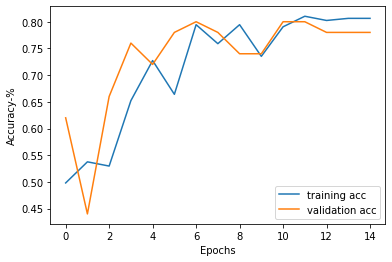

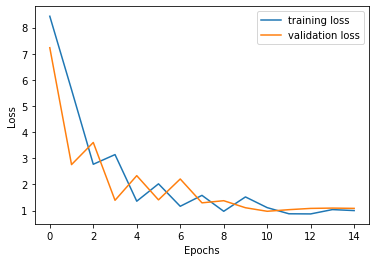

In [ ]:
# plot learning curve
def plot_learning_curve(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, label='training acc')
    plt.plot(epochs, val_acc, label='validation acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy-%')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, label='training loss')
    plt.plot(epochs, val_loss, label='validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

plot_learning_curve(history)

In [ ]:
ypred_val = model_vgg19.predict(test_ds[0][0])
ypred_val = np.array([1 if x > 0.5 else 0 for x in ypred_val])
y_val = test_ds[0][-1]

print('Confusion_Matrix:\n',confusion_matrix(y_val, ypred_val))
print('\nClassification_report:\n',classification_report(ypred_val,y_val))

Confusion_Matrix:
 [[11  8]
 [ 3 28]]

Classification_report:
               precision    recall  f1-score   support

           0       0.58      0.79      0.67        14
           1       0.90      0.78      0.84        36

    accuracy                           0.78        50
   macro avg       0.74      0.78      0.75        50
weighted avg       0.81      0.78      0.79        50



## **InceptionV3**

In [ ]:
#INCEPTIONV3

height = 299
width = 299

train_ds, test_ds = image_generator(height,width)

tf.keras.backend.clear_session()
input_shape = (height, width, 3)
base_model = tf.keras.applications.InceptionV3(
    weights='imagenet',
    include_top=False,
    input_shape=input_shape
)
base_model.trainable = False

model_inceptionv3 = tf.keras.Sequential()
model_inceptionv3.add(base_model)
model_inceptionv3.add(tf.keras.layers.Flatten())
model_inceptionv3.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_inceptionv3.compile(
                    loss='binary_crossentropy',
                    optimizer=tf.keras.optimizers.Adam(0.001),
                    metrics=['acc']
)
model_inceptionv3.summary()

Found 203 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 131072)            0         
                                                                 
 dense (Dense)               (None, 1)                 131073    
                                                                 
Total params: 21,933,857
Trainable params: 131,073
Non-trainable params: 21,802,784
_________________________________________________________________


In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('model/inceptionv3_best.h5', monitor='acc', verbose=1, mode='max',save_best_only=True)

aug_train_ds = augmentataion_generator(height,width)

early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min",restore_best_weights=True, patience=5)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='acc', factor=0.3,
                              patience=3, min_lr=0.0000001)

callbacks_list = [checkpoint,early,reduce_lr]

history = model_inceptionv3.fit(
        aug_train_ds,
        validation_data=test_ds,
        epochs=15,
        #shuffle=True,
        verbose=True,
        callbacks=callbacks_list)

Found 253 images belonging to 2 classes.
Epoch 1/15
2/2 [==============================] - ETA: 0s - loss: 1.4458 - acc: 0.6245 
Epoch 1: acc improved from -inf to 0.62451, saving model to model/inceptionv3_best.h5
2/2 [==============================] - 88s 49s/step - loss: 1.4458 - acc: 0.6245 - val_loss: 6.8188 - val_acc: 0.4800 - lr: 0.0010
Epoch 2/15
2/2 [==============================] - ETA: 0s - loss: 3.5082 - acc: 0.6008 
Epoch 2: acc did not improve from 0.62451
2/2 [==============================] - 70s 37s/step - loss: 3.5082 - acc: 0.6008 - val_loss: 0.6833 - val_acc: 0.8800 - lr: 0.0010
Epoch 3/15
2/2 [==============================] - ETA: 0s - loss: 2.8705 - acc: 0.7194 
Epoch 3: acc improved from 0.62451 to 0.71937, saving model to model/inceptionv3_best.h5
2/2 [==============================] - 85s 51s/step - loss: 2.8705 - acc: 0.7194 - val_loss: 0.5574 - val_acc: 0.9200 - lr: 0.0010
Epoch 4/15
2/2 [==============================] - ETA: 0s - loss: 1.3566 - acc: 0.814

In [ ]:
train_result = model_inceptionv3.evaluate(aug_train_ds)
test_result = model_inceptionv3.evaluate(test_ds)

augmented_df = pd.DataFrame(zip(train_result,test_result),columns=['Train','Test'],index=['Loss','Acc'])
augmented_df

1/1 [==============================] - 11s 11s/step - loss: 0.2160 - acc: 0.9400


,Train,Test
Loss,0.355975,0.215994
Acc,0.913043,0.940000


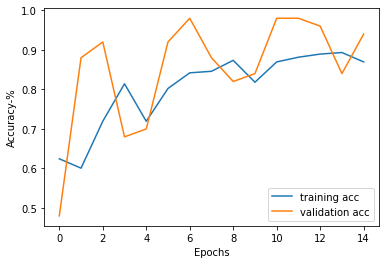

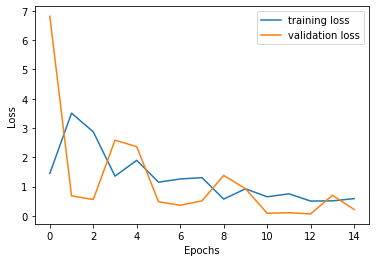

In [ ]:
plot_learning_curve(history)

In [ ]:
ypred = model_inceptionv3.predict(test_ds[0][0])
ypred = np.array([1 if x > 0.5 else 0 for x in ypred])
#ypred = ypred.astype(int)
ytest = test_ds[0][-1]

print('Confusion_Matrix:\n',confusion_matrix(ytest, ypred))
print('\nClassification_report:\n',classification_report(ypred,ytest))

Confusion_Matrix:
 [[19  0]
 [ 3 28]]

Classification_report:
               precision    recall  f1-score   support

           0       1.00      0.86      0.93        22
           1       0.90      1.00      0.95        28

    accuracy                           0.94        50
   macro avg       0.95      0.93      0.94        50
weighted avg       0.95      0.94      0.94        50



## **ResNet50**

In [ ]:
from tensorflow.keras.layers.experimental import preprocessing

tf.keras.backend.clear_session()
input_shape = (299, 299, 3)
base_model = tf.keras.applications.resnet50.ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=input_shape
)
base_model.trainable = False

model_resnet50 = tf.keras.Sequential()
model_resnet50.add(base_model)
model_resnet50.add(tf.keras.layers.Flatten())

model_resnet50.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_resnet50.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(0.01),
              metrics=['acc'])
model_resnet50.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 10, 10, 2048)      23587712  
                                                                 
 flatten (Flatten)           (None, 204800)            0         
                                                                 
 dense (Dense)               (None, 1)                 204801    
                                                                 
Total params: 23,792,513
Trainable params: 204,801
Non-trainable params: 23,587,712
_________________________________________________________________


In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('model/resnet50_best.h5', monitor='acc', verbose=1, mode='max',save_best_only=True)

aug_train_ds = augmentataion_generator(height,width)

early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min",restore_best_weights=True, patience=5)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='acc', factor=0.3,
                              patience=3, min_lr=0.0000001)

callbacks_list = [checkpoint,early,reduce_lr]

history = model_resnet50.fit(
        aug_train_ds,
        validation_data=test_ds,
        epochs=15,
        #shuffle=True,
        verbose=True,
        callbacks=callbacks_list)

Found 253 images belonging to 2 classes.
Epoch 1/15
2/2 [==============================] - ETA: 0s - loss: 73.7696 - acc: 0.5968
Epoch 1: acc improved from -inf to 0.59684, saving model to model/resnet50_best.h5
2/2 [==============================] - 101s 54s/step - loss: 73.7696 - acc: 0.5968 - val_loss: 52.3542 - val_acc: 0.6200 - lr: 0.0100
Epoch 2/15
2/2 [==============================] - ETA: 0s - loss: 86.5890 - acc: 0.4941 
Epoch 2: acc did not improve from 0.59684
2/2 [==============================] - 93s 51s/step - loss: 86.5890 - acc: 0.4941 - val_loss: 104.6142 - val_acc: 0.3800 - lr: 0.0100
Epoch 3/15
2/2 [==============================] - ETA: 0s - loss: 76.4022 - acc: 0.3874  
Epoch 3: acc did not improve from 0.59684
2/2 [==============================] - 92s 48s/step - loss: 76.4022 - acc: 0.3874 - val_loss: 57.7618 - val_acc: 0.6200 - lr: 0.0100
Epoch 4/15
2/2 [==============================] - ETA: 0s - loss: 86.8867 - acc: 0.6126 
Epoch 4: acc improved from 0.59684 

In [ ]:
train_result = model_resnet50.evaluate(aug_train_ds)
test_result = model_resnet50.evaluate(test_ds)

augmented_df = pd.DataFrame(zip(train_result,test_result),columns=['Train','Test'],index=['Loss','Acc'])
augmented_df

1/1 [==============================] - 14s 14s/step - loss: 13.0143 - acc: 0.6800


,Train,Test
Loss,12.047807,13.014296
Acc,0.549407,0.680000


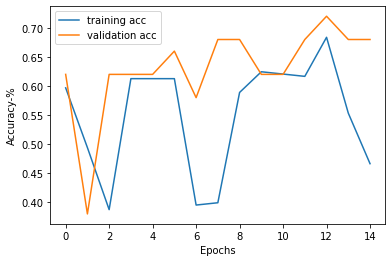

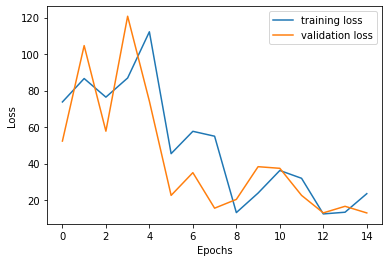

In [ ]:
plot_learning_curve(history)

In [ ]:
ypred = model_resnet50.predict(test_ds[0][0])
ypred = np.array([1 if x > 0.5 else 0 for x in ypred])

ytest = test_ds[0][-1]

print('Confusion_Matrix:\n',confusion_matrix(ytest, ypred))
print('\nClassification_report:\n',classification_report(ypred,ytest))

Confusion_Matrix:
 [[11  8]
 [ 8 23]]

Classification_report:
               precision    recall  f1-score   support

           0       0.58      0.58      0.58        19
           1       0.74      0.74      0.74        31

    accuracy                           0.68        50
   macro avg       0.66      0.66      0.66        50
weighted avg       0.68      0.68      0.68        50

